### This notebook prepares spike-based auditory inputs for a future Liquid State Machine

In [1]:
!pip install samna

In [3]:
from zipfile import ZipFile
import os
from IPython.display import Image, Audio, display
import numpy as np
import scipy as sp
import librosa
import random
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm
import gc

from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TimeSeries, TSContinuous
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from rockpool.nn.modules import LIFTorch, LinearTorch, ExpSynTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.utilities.backend_management import backend_available

In [4]:
train_segments_path = r'''C:\Users\CKOTHARI\OneDrive - Volvo Cars\Documents\Chirag\LTU\12. Neuromorphic Computing\Project\building_106_kitchen\training_segments'''
test_sequence_path = r'''C:\Users\CKOTHARI\OneDrive - Volvo Cars\Documents\Chirag\LTU\12. Neuromorphic Computing\Project\building_106_kitchen\test_sequence'''


## Convert and plot one sample

In [5]:
# parameters for AFESim
fs = 110e3                          # The sampling frequency of the input, in Hz
raster_period = 10e-3               # The output rasterisation time-step in seconds
max_spike_per_raster_period = 15    # Maximum number of events per output time-step

# set them false for now
add_noise = False                   # Enables / disables simulated noise generated by the AFE
add_offset = False                  # Add mismatch offset to each filter
add_mismatch = False                # Add simualted mismatch to filter parameters
seed = None                         # Seed for mistmatch generation

In [6]:
# should input AFESim and path to .wav file and ouput spike representation
def wav_to_spikes(path, afe):
    audio, sr = librosa.load(path, sr=None, mono=True)
    print(audio)

    # create a time vector for time series object
    times = np.arange(len(audio)) / sr

    # rockpool continuous time series
    ts_audio = TSContinuous(times, audio[:, None])

    # pass through AFESim
    spikes, state, rec = afe(ts_audio)

    return spikes, state, rec


In [7]:
# initialize the AFE simulation
afe = AFESim(
        fs = fs,
        raster_period = raster_period,
        max_spike_per_raster_period = max_spike_per_raster_period,
        add_noise = add_noise,
        add_offset = add_offset,
        add_mismatch = add_mismatch,
        seed = seed,
).timed()

## Note on plot
We can see here that the AFE simulation has 16 outputs, and this is because of a band-pass filter bank which splits the (audio) signal into 16 bands. The lowest band, index 0, has a centre frequency of 40 and the highest band, index 15, has a centre frequency of 16940, as shown in the code cell just below. I believe we should be able to tune the bands if we wanted to. [AFESim documentation](https://rockpool.ai/reference/_autosummary/devices.xylo.syns61201.AFESim.html) shows a bunch of parameters we might be interested in looking at or even tuning.

In [8]:
print("Center frequencies:", afe.module.fcs)

Center frequencies: [   40.    54.    77.   137.   203.   290.   428.   674.  1177.  1700.
  2226.  3418.  5154.  7884. 11630. 16940.]


## Custom dataset loader
Because we have our own dataset, unlike the tutorial we can't use Tonic to create datloaders, but create a custom dataset class. We also need to convert every single .wav file to a tensor, which is very computationally heavy.

In [9]:
class SpikeRasterDataset(Dataset):
    def __init__(self, sample_info_path, transform=None):
        self.sample_info = np.load(sample_info_path, allow_pickle=True)
        self.transform = transform

    def __len__(self):
        return len(self.sample_info)

    def __getitem__(self, idx):
        spike_path, class_idx = self.sample_info[idx]
        spikes = np.load(spike_path)  # shape (T, C)
        if self.transform is not None:
            spikes = self.transform(spikes)
        # convert to float tensor
        spikes = torch.from_numpy(spikes).float()
        return spikes, class_idx

In [10]:
# REBUILD sample_info.npy (FIX PATHS)

import os
import numpy as np

base_path = r"C:\Users\CKOTHARI\OneDrive - Volvo Cars\Documents\Chirag\LTU\12. Neuromorphic Computing\Project\kitchen_spike_dataset"

sample_info = []

for class_idx, class_name in enumerate(sorted(os.listdir(base_path))):
    class_dir = os.path.join(base_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if fname.endswith(".npy"):
            sample_info.append((os.path.join(class_dir, fname), class_idx))

sample_info = np.array(sample_info, dtype=object)

save_path = os.path.join(base_path, "sample_info.npy")
np.save(save_path, sample_info)

print(f"Saved {len(sample_info)} samples to {save_path}")

Saved 1518 samples to C:\Users\CKOTHARI\OneDrive - Volvo Cars\Documents\Chirag\LTU\12. Neuromorphic Computing\Project\kitchen_spike_dataset\sample_info.npy


In [11]:
dataset_path = r'''C:\Users\CKOTHARI\OneDrive - Volvo Cars\Documents\Chirag\LTU\12. Neuromorphic Computing\Project\kitchen_spike_dataset\sample_info.npy'''
dataset = SpikeRasterDataset(dataset_path)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print("train set size:\t",train_size)
print("val set size:\t",val_size)
print("test set size:\t",test_size)
print("total size:\t",total_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

train set size:	 1062
val set size:	 227
test set size:	 229
total size:	 1518


Spike shape: (300, 16)
Label: 1


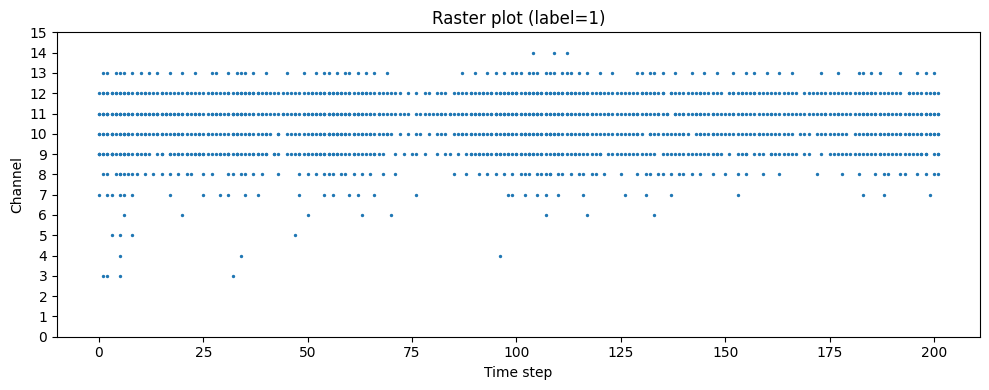

From metadata:
class_to_idx
 background: 0
 bag: 1
 blender: 2
 cornflakes_bowl: 3
 cornflakes_eating: 4
 cup: 5
 dish_washer: 6
 electric_razor: 7
 flatware_sorting: 8
 food_processor: 9
 hair_dryer: 10
 microwave: 11
 microwave_bell: 12
 microwave_door: 13
 plates_sorting: 14
 stirring_cup: 15
 toaster_up_down: 16
 toilet_button: 17
 toilet_flush: 18
 tooth: 19
 vacuum_cleaner: 20
 washing_machine: 21
 water_boiler: 22
 water_tap: 23



In [12]:
# visualize any sample just to make sure it looks ok
sample_info = np.load(dataset_path, allow_pickle=True)

spike_path, label = sample_info[99]
spikes = np.load(spike_path)

print("Spike shape:", spikes.shape)
print("Label:", label)

def plot_spike_raster(spikes, title=None):
    T, C = spikes.shape

    times = []
    channels = []

    for t in range(T):
        for c in range(C):
            count = int(spikes[t, c])
            if count > 0:
                times.extend([t] * count)
                channels.extend([c] * count)

    plt.figure(figsize=(10, 4))
    plt.scatter(times, channels, s=2)
    plt.xlabel("Time step")
    plt.ylabel("Channel")
    plt.yticks(range(C))
    plt.title(title or "Spike Raster Plot")
    plt.tight_layout()
    plt.show()

plot_spike_raster(spikes, title=f"Raster plot (label={label})")

print("From metadata:\nclass_to_idx\n",
    "background: 0\n",
    "bag: 1\n",
    "blender: 2\n",
    "cornflakes_bowl: 3\n",
    "cornflakes_eating: 4\n",
    "cup: 5\n",
    "dish_washer: 6\n",
    "electric_razor: 7\n",
    "flatware_sorting: 8\n",
    "food_processor: 9\n",
    "hair_dryer: 10\n",
    "microwave: 11\n",
    "microwave_bell: 12\n",
    "microwave_door: 13\n",
    "plates_sorting: 14\n",
    "stirring_cup: 15\n",
    "toaster_up_down: 16\n",
    "toilet_button: 17\n",
    "toilet_flush: 18\n",
    "tooth: 19\n",
    "vacuum_cleaner: 20\n",
    "washing_machine: 21\n",
    "water_boiler: 22\n",
    "water_tap: 23\n"
  )

Note: some of theses files seem to contain no spikes at all. We should consider filtering them out.

# Training algorithm


In [13]:
import torch
import torch.nn as nn

class SpikeClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: [batch, time, channels]
        x = x.sum(dim=1)     # temporal pooling
        return self.net(x)


In [14]:
num_classes = 26   # your max label + 1
input_dim = 16     # AFESim channels

model = SpikeClassifier(input_dim, num_classes)


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


In [16]:
loss_history = []
accuracy_history = []

for epoch in range(10):
    total_loss = 0
    correct = 0
    total = 0

    for spikes, labels in train_loader:
        spikes = spikes.float()
        labels = labels.long()

        logits = model(spikes)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    acc = 100 * correct / total

    loss_history.append(avg_loss)
    accuracy_history.append(acc)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={acc:.2f}%")


Epoch 1: Loss=93.2919, Acc=10.08%
Epoch 2: Loss=27.5837, Acc=24.20%
Epoch 3: Loss=12.5994, Acc=35.12%
Epoch 4: Loss=6.7562, Acc=46.14%
Epoch 5: Loss=4.4613, Acc=56.03%
Epoch 6: Loss=3.7281, Acc=57.16%
Epoch 7: Loss=2.5937, Acc=63.28%
Epoch 8: Loss=1.8291, Acc=68.17%
Epoch 9: Loss=1.9182, Acc=70.24%
Epoch 10: Loss=1.7452, Acc=73.92%


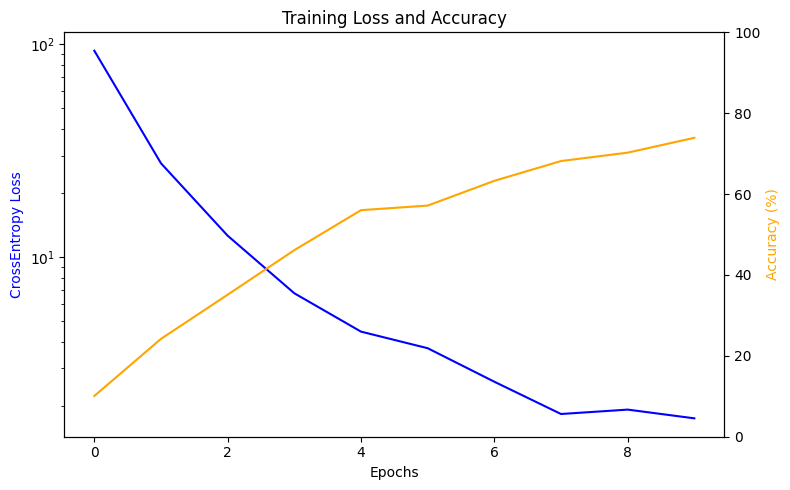

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot loss
ax.plot(loss_history, color='blue')
ax.set_ylabel('CrossEntropy Loss', color='blue')
ax.set_xlabel('Epochs')
ax.set_yscale('log')

# Accuracy on secondary axis
ax2 = ax.twinx()
ax2.plot(accuracy_history, color='orange')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.set_ylim(0, 100)

plt.title('Training Loss and Accuracy')
plt.tight_layout()
plt.show()


In [18]:
model.eval()

correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for spikes, labels in test_loader:
        spikes = spikes.float()
        labels = labels.long()

        # Forward pass
        logits = model(spikes)

        # Loss
        loss = loss_fn(logits, labels)
        test_loss += loss.item()

        # Predictions
        preds = torch.argmax(logits, dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

# Final metrics
test_accuracy = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 2.7990
Test Accuracy: 64.19%


After extensive implementation and debugging, we found that a full Liquid State Machine (LSM) implementation is not feasible in our current setup.

The main limitation is that the official Rockpool LSM framework depends on hardware-specific backends (e.g., Xylo / Samna) that are not supported on our current environment (Windows). Because of this, the reservoir dynamics cannot be executed or trained correctly.

Additionally, Rockpool’s LSM design uses fixed (non-trainable) reservoirs, meaning only the readout layer can be trained. Attempting to train the full network using standard PyTorch optimizers results in errors, as the reservoir parameters are not differentiable.

Although a simplified software-based spiking model was tested, it does not represent a true LSM and does not provide meaningful learning behavior for our dataset.

Therefore, implementing a full, functional LSM was not technically feasible under the current constraints. A different model or platform (e.g., Linux + hardware-supported neuromorphic backend) would be required for a proper LSM implementation.

We have tried to model the sensory front end but reservoir and readout layer was not feasible and we had our above limitations.